In [1]:
%load_ext autoreload
%autoreload 2

# Information maximiser

Using neural networks, sufficient statistics can be obtained from data by maximising the Fisher information.

The neural network takes some data ${\bf d}$ and maps it to a compressed summary $\mathscr{f}:{\bf d}\to{\bf x}$ where ${\bf x}$ can have the same size as the dimensionality of the parameter space, rather than the data space.

To train the neural network a batch of simulations ${\bf d}_{\sf sim}^{\sf fid}$ created at a fiducial parameter value $\boldsymbol{\theta}^{\rm fid}$ are compressed by the neural network to obtain ${\bf x}_{\sf sim}^{\sf fid}$. From this we can calculate the covariance ${\bf C_\mathscr{f}}$ of the compressed summaries. We learn about model parameter distributions using the derivative of the simulation. This can be provided analytically or numercially using ${\bf d}_{\sf sim}^{\sf fid+}$ created above the fiducial parameter value $\boldsymbol{\theta}^{\sf fid+}$ and ${\bf d}_{\sf sim}^{\sf fid-}$ created below the fiducial parameter value $\boldsymbol{\theta}^{\sf fid-}$. The simulations are compressed using the network and used to find mean of the summaries 
$$\frac{\partial\boldsymbol{\mu}_\mathscr{f}}{\partial\theta_\alpha}=\frac{1}{n_\textrm{derivs}}\sum_{i=1}^{n_\textrm{derivs}}\frac{{\bf x}_{\sf sim}^{\sf fid+}-{\bf x}_{\sf sim}^{\sf fid-}}{\boldsymbol{\theta}^{\sf fid+}-\boldsymbol{\theta}^{\sf fid-}}.$$
If the derivative of the simulations with respect to the parameters can be calculated analytically (or via autograd, etc.) then that can be used directly using the chain rule since the derivative of the network outputs with respect to the network input can be calculated easily
$$\frac{\partial\mu_\mathscr{f}}{\partial\theta_\alpha} = \frac{1}{n_{\textrm{sims}}}\sum_{i=1}^{n_{\textrm{sims}}}\frac{\partial{\bf x}_i}{\partial{\bf d}_j}\frac{\partial{\bf d}_j}{\partial\theta_\alpha}\delta_{ij}.$$
We then use ${\bf C}_\mathscr{f}$ and $\boldsymbol{\mu}_\mathscr{f},_\alpha$ to calculate the Fisher information
$${\bf F}_{\alpha\beta} = \boldsymbol{\mu}_\mathscr{f},^T_{\alpha}{\bf C}^{-1}_\mathscr{f}\boldsymbol{\mu}_\mathscr{f},_{\beta}.$$
We want to maximise the Fisher information, and we want the summaries to be orthogonal so to train the network we minimise the loss function
    $$\Lambda = -\ln|{\bf F}_{\alpha\beta}|+r(\Lambda_2)\Lambda_2$$
where 
    $$\Lambda_2 = ||{\bf C}_\mathscr{f}-\mathbb{1}||_2 + ||{\bf C}_\mathscr{f}^{-1}-\mathbb{1}||_2$$
is a regularisation term whose strength is dictated by 
    $$r(\Lambda_2) = \frac{\lambda\Lambda_2}{\Lambda_2 + \exp(-\alpha\Lambda_2)}$$
where $\lambda$ is a strength and $\alpha$ is a rate parameter which can be determined from a closeness condition on the Frobenius norm of the difference between the convariance (and inverse covariance) from the identity matrix.

When using this code please cite <a href="https://arxiv.org/abs/1802.03537">arXiv:1802.03537</a>.<br><br>
The code in the paper can be downloaded as v1 or v1.1 of the code kept on zenodo:<br><br>
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1175196.svg)](https://doi.org/10.5281/zenodo.1175196)
<br>

This code is run using<br>
>`python v3.7.4`

>`tensorflow==2.0.0`

>`numpy==1.16.2`

>`tqdm==4.31.1`

Although these precise versions may not be necessary, I have put them here to avoid possible conflicts. 

## Load modules

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IMNN import IMNN
from IMNN.ABC import ABC, priors

# Summarising the mean and the variance

For this example we are going to use $n_{\bf d}=10$ data points of a 1D field of Gaussian noise with unknown mean and variance to see if the network can learn to summarise them.<br><br>

The likelihood is given by
$$\mathcal{L} = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

We can solve this problem analytically, so it is useful to check how well the network does. There is a single sufficient statistic which describes each the mean and the variance, which can be found by finding the maximum of the probability. We find that
$$\sum_i^{n_{\bf d}}d_i = \mu\textrm{ and }\sum_i^{n_{\bf d}}(d_i-\mu)^2=n_{\bf d}\Sigma$$

We can calculate the Fisher information by taking the negative of second derivative of the likelihood taking the expectation by inserting the above relations at examining at some fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$
If we choose a fiducial mean of $\mu^{\textrm{fid}}=0$ and variance of $\Sigma^{\textrm{fid}} = 1$ then we obtain a Fisher information matrix of




In [3]:
input_shape = (10,)

n_params = 2
θ_fid = np.array([0, 1.])

determinant of the Fisher information 50.000000000000014


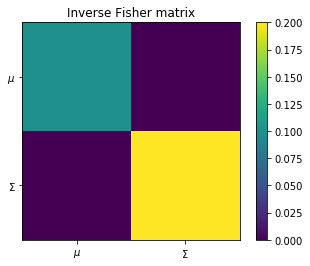

In [4]:
exact_fisher = -np.array([[-input_shape[0] / θ_fid[1], 0.], [0. , - 0.5 * input_shape[0] / θ_fid[1]**2.]])
determinant_exact_fisher = np.linalg.det(exact_fisher)
print("determinant of the Fisher information", determinant_exact_fisher)
plt.imshow(np.linalg.inv(exact_fisher))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

Let us observe our _real_ data which happens to have true parameters $\mu=3$ and $\Sigma=2$

In [5]:
real_data = np.random.normal(3., np.sqrt(2.), size = (1,) + input_shape)

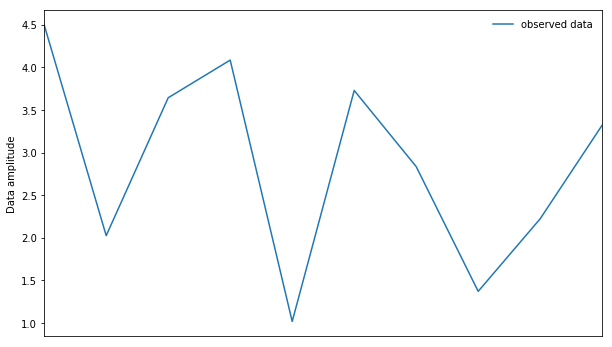

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(real_data[0], label = "observed data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

The posterior distribution for this data (normalised to integrate to 1) is

In [7]:
μ_array = np.linspace(-10, 10, 1000)
Σ_array = np.linspace(0.001, 10, 1000)

parameter_grid = np.array(np.meshgrid(μ_array, Σ_array, indexing = "ij"))
dx = (μ_array[1] - μ_array[0]) * (Σ_array[1] - Σ_array[0])

analytic_posterior = np.exp(-0.5 * (np.sum((real_data[0][:, np.newaxis] - parameter_grid[0, :, 0][np.newaxis, :])**2., axis = 0)[:, np.newaxis] / parameter_grid[1, 0, :][np.newaxis, :] + real_data.shape[1] * np.log(2. * np.pi * parameter_grid[1, 0, :][np.newaxis, :])))
analytic_posterior = analytic_posterior.T / np.sum(analytic_posterior * dx)

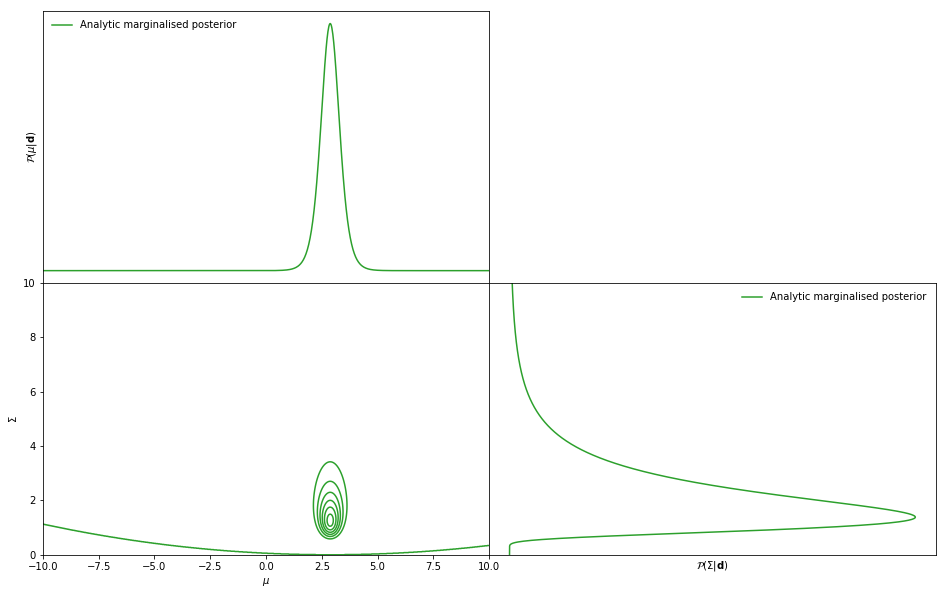

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior, axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 1].plot(np.sum(analytic_posterior, axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

Now lets see how the information maximising neural network can recover this posterior.

## Generate data

We start by defining a function to generate the data with the correct shape. The shape must be
```
data_shape = (None,) + input_shape
```

It is useful to define the generating function so that it only takes in the value of the parameter as its input since the function can then be used for ABC later.<br><br>
The data needs to be generated at a fiducial parameter value and at perturbed values just below and above the fiducial parameter for the numerical derivative. 

In [9]:
δθ = np.array([0.1, 0.1])

The training and validation data should be generated at the perturbed values with shape
```
perturbed_data_shape = (None, 2, n_params) + input_shape
```
if using numerical derivatives, where `[:, 0, ...]` is the parameter at `Δθpm` below `θ_fid` and `[:, 1, ...]` is the parameter at `Δθpm` above `θ_fid`. This is done for each parameter keeping ever non-perturbed parameter at its fiducial parameter.

If the true derivative of the simulations with respect to the parameters is available then this can be calculated for each fiducial simulation in the dataset with shape
```
derivative_data_shape = (None, n_params) + input_shape
```

The generating function is defined so that the fiducial parameter is passed as a list so that many simulations can be made at once. This is very useful for the ABC function later.

In [10]:
def simulator(θ, seed, simulator_args):
    if seed is not None:
        np.random.seed(seed)
    if len(θ.shape) > 1:
        μ = θ[:, 0]
        Σ = θ[:, 1]
    else:
        μ = 0.
        Σ = θ
    return np.moveaxis(np.random.normal(μ, np.sqrt(Σ), simulator_args["input shape"] + (θ.shape[0],)), -1, 0)

### Training data
Enough data needs to be made to approximate the covariance matrix of the output summaries. The number of simulations needed to approximate the covariance is `n_s`. We can make stochastic updates by making `n_train` more simulations than are needed to approximate the covariance. `n_train` should be an integer number.

In [11]:
n_s = 1000
n_train = 1
seed = np.random.randint(1e6)

The training data can now be made

In [12]:
d = simulator(θ = np.tile(θ_fid, [n_train * n_s, 1]), seed = seed, simulator_args = {"input shape": input_shape})

Ideally we would be able to take the derivative of our simulations with respect to the model parameters. We can indeed do that in this case, but since this is possibly a rare occurance I will show an example where the derivatives are calculated numerically. By suppressing the sample variance between the simulations created at some lower and upper varied parameter values, far fewer simulations are needed. We should choose the extra `n_train` simulations for the stochastic updates to be the same as for the fiducial simulations.

In [13]:
n_d = 1000

The sample variance is supressed by choosing the same initial seed when creating the upper and lower simulations.

In [14]:
dd_m_dθ = simulator(θ = np.tile(θ_fid - np.array([0.1, 0.]), [n_train * n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})
dd_p_dθ = simulator(θ = np.tile(θ_fid + np.array([0.1, 0.]), [n_train * n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})
dd_m_dθ = np.stack([dd_m_dθ, simulator(θ = np.tile(θ_fid - np.array([0., 0.1]), [n_train * n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
dd_p_dθ = np.stack([dd_p_dθ, simulator(θ = np.tile(θ_fid + np.array([0., 0.1]), [n_train * n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
dd_dθ_num = np.concatenate([dd_m_dθ[:, np.newaxis, ...], dd_p_dθ[:, np.newaxis, ...]], axis=1)
dd_dθ = (dd_p_dθ - dd_m_dθ) / (2. * δθ)[np.newaxis, :, np.newaxis]

### Test data
We should also make some test data, but here we will use only one combination. This needs adding to the dictionary

In [15]:
seed = np.random.randint(1e6)
td = simulator(θ = np.tile(θ_fid, [n_s, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tdd_m_dθ = simulator(θ = np.tile(θ_fid - np.array([0.1, 0.]), [n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tdd_p_dθ = simulator(θ = np.tile(θ_fid + np.array([0.1, 0.]), [n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})
tdd_m_dθ = np.stack([tdd_m_dθ, simulator(θ = np.tile(θ_fid - np.array([0., 0.1]), [n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
tdd_p_dθ = np.stack([tdd_p_dθ, simulator(θ = np.tile(θ_fid + np.array([0., 0.1]), [n_d, 1]), seed = seed, simulator_args = {"input shape": input_shape})], axis = 1)
tdd_dθ_num = np.concatenate([tdd_m_dθ[:, np.newaxis, ...], tdd_p_dθ[:, np.newaxis, ...]], axis=1)
tdd_dθ = (tdd_p_dθ - tdd_m_dθ) / (2. * δθ)[np.newaxis, :, np.newaxis]

### Data visualisation
We can plot the data to see what it looks like.

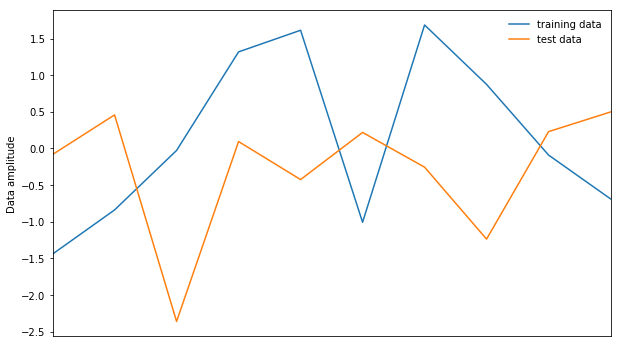

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(d[np.random.randint(n_train * n_s)], label = "training data")
ax.plot(td[np.random.randint(n_s)], label = "test data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

It is also very useful to plot the upper and lower derivatives to check that the sample variance is actually supressed since the network learns extremely slowly if this isn't done properly.

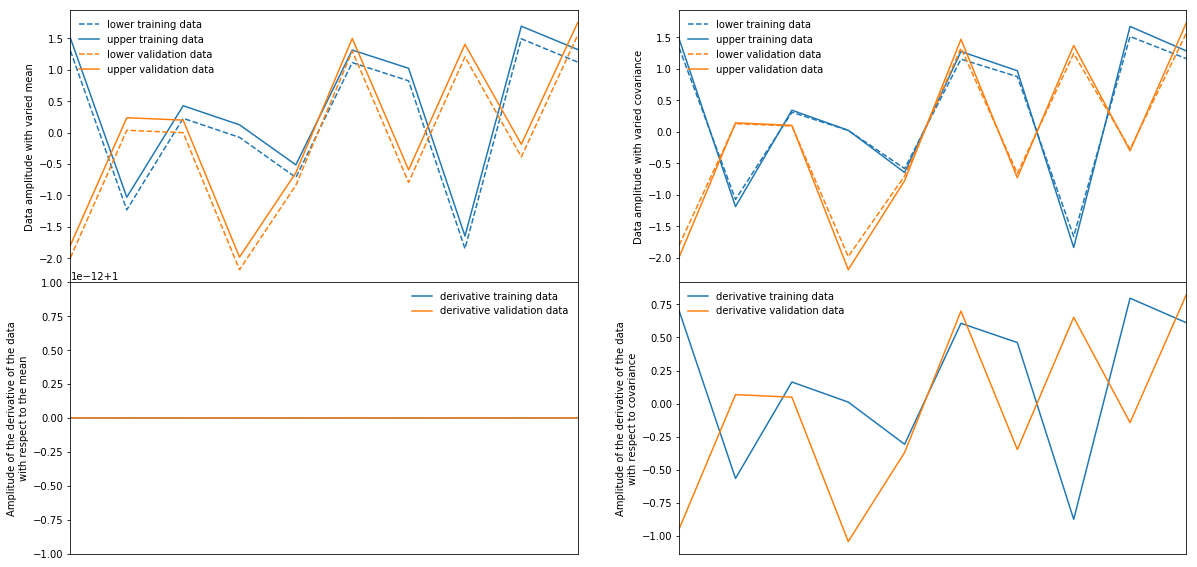

In [17]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
plt.subplots_adjust(hspace = 0)
training_index = np.random.randint(n_train * n_d)
test_index = np.random.randint(n_d)

ax[0, 0].plot(dd_m_dθ[training_index, 0], label = "lower training data", color = "C0", linestyle = "dashed")
ax[0, 0].plot(dd_p_dθ[training_index, 0], label = "upper training data", color = "C0")
ax[0, 0].plot(tdd_m_dθ[test_index, 0], label = "lower validation data", color = "C1", linestyle = "dashed")
ax[0, 0].plot(tdd_p_dθ[test_index, 0], label = "upper validation data", color = "C1")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([0, 9])
ax[0, 0].set_xticks([])
ax[0, 0].set_ylabel("Data amplitude with varied mean")
ax[1, 0].plot(dd_dθ[training_index, 0], label = "derivative training data", color = "C0")
ax[1, 0].plot(tdd_dθ[test_index, 0], label = "derivative validation data", color = "C1")
ax[1, 0].set_xlim([0, 9])
ax[1, 0].set_xticks([])
ax[1, 0].legend(frameon = False)
ax[1, 0].set_ylabel("Amplitude of the derivative of the data\nwith respect to the mean");

ax[0, 1].plot(dd_m_dθ[training_index, 1], label = "lower training data", color = "C0", linestyle = "dashed")
ax[0, 1].plot(dd_p_dθ[training_index, 1], label = "upper training data", color = "C0")
ax[0, 1].plot(tdd_m_dθ[test_index, 1], label = "lower validation data", color = "C1", linestyle = "dashed")
ax[0, 1].plot(tdd_p_dθ[test_index, 1], label = "upper validation data", color = "C1")
ax[0, 1].legend(frameon = False)
ax[0, 1].set_xlim([0, 9])
ax[0, 1].set_xticks([])
ax[0, 1].set_ylabel("Data amplitude with varied covariance")
ax[1, 1].plot(dd_dθ[training_index, 1], label = "derivative training data", color = "C0")
ax[1, 1].plot(tdd_dθ[test_index, 1], label = "derivative validation data", color = "C1")
ax[1, 1].set_xlim([0, 9])
ax[1, 1].set_xticks([])
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylabel("Amplitude of the derivative of the data\nwith respect to covariance");

## Initiliase the neural network

We will choose a fairly generic network as an example here. These networks can be written in TensorFlow or keras. It must be able to take in `(None,) + input_shape` and `(None, n_params) + input_shape` or `(None, 2, n_params) + input_shape` and output a flat array with `n_summaries` outputs, i.e. `(None, n_summaries` and `(None, n_params, n_summaries)` or `(None, 2, n_params, n_summaries)`. 

In principle `n_summaries` can be any number, but information loss is guaranteed if `n_summaries < n_params` and we overparameterise the summaries if we use `n_summaries>n_params`. Therefore, in principle, we should use `n_summaries=n_params`. Note that this isn't necessarily true if external informative summaries are included in the training.

In [18]:
n_summaries = n_params

In keras we shall define a network with two hidden layers with 128 hidden nodes in each and every layer apart from the output activated using `tanh`. We shall optimise the network using the `Adam` optimiser on its default settings

In [19]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=input_shape),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(n_summaries),
    ])
opt = tf.keras.optimizers.Adam()

## Initialise the IMNN module

The IMNN only needs to be provided with the number of parameters in the model, the number of summaries output by the network and the number of simulations needed to approximate the covariance of the summaries and to approximate the mean of the derivative of the summaries with respect to the parameters. Optionally we can also choose whether to use 32 or 64 bit floats (and ints) in TensorFlow and choose whether or not to get verbose size checking whilst loading the model and the data.

In [20]:
imnn = IMNN.IMNN(n_params=n_params, n_summaries=n_summaries, n_covariance_sims=n_s, n_derivative_sims=n_d, dtype=tf.float32, verbose=True)

Using single dataset


The network is then passed to the module using

In [21]:
imnn.set_model(model=model, optimiser=opt)

Checking is not currently done on the model. Make sure that its output has shape (None, 2) for the fiducial values a nd (None, 2, 2, 2) for the derivative values.


## Load the data

The data is passed as a TensorFlow data set for extremely quick and efficient transfer to GPUs, etc. For most reasonable sized datasets (GPU/CPU memory dependent of course) we can load this using

In [22]:
imnn.setup_dataset(θ_fid=θ_fid, d=d, dd_dθ=dd_dθ_num, δθ=δθ, external_summaries=None, external_derivatives=None)

Since we might already know some very informative summaries of the data, we can include these. To do so the external summaries can be passed to the above function as numpy arrays. The summaries must have the same structure as the data (and aligned with the data) where `input_shape` is replaced with a flat array with `n_external` elements.

The dataset can be setup externally by setting the data attributes 
```python
imnn.dataset = tf.data.Dataset.from_tensor_slices(data)
imnn.dataset = imnn.dataset.batch(imnn.n_s)
imnn.dataset = imnn.dataset.shuffle(n_train * imnn.n_s)
```
where `data=(fiducial_data, derivative_data)` is a tuple containing the fiducial and the derivative simulations. If the number of parameters for the mean of the derivatives is different to the number needed for the covariance then `data` should not be a tuple and instead just contain the fiducial simulations and instead the derivatives can be passed as
```python
imnn.derivative_dataset = tf.data.Dataset.from_tensor_slices(derivative_data)
imnn.dataset = imnn.dataset.batch(imnn.n_d)
imnn.dataset = imnn.dataset.shuffle(n_train * imnn.n_d)
``` 
If the derivative is done numerically then `imnn.numerical=True` must be set, and likewise `imnn.numerical=False` must be used otherwise. The fiducial parameters should be set using
```python
imnn.θ_fid = tf.Variable(θ_fid, dtype=imnn.dtype)
```
and if using the numerical derivative we also need to set
```python
imnn.δθ = tf.Variable(1. / (2. * δθ), dtype=imnn.dtype)
```
If external informative summaries are going to be used then the when the number of simulations for the derivative of the mean of the summaries and the number of simulations for the covariance of the summaries is the same the data tuple should be `data=(fiducial_data, derivative_data, external_summaries, external_derivatives)` and when then number is different the tuples should be different `data=(fiducial_data, external_summaries`) and `derivatives=(derivative_data, external_derivatives)`.

Although there is little point in doing the above externally, this could be extremely useful for large datasets which are written as TFRecords.

The validation data can be passed using

In [23]:
imnn.setup_dataset(θ_fid=θ_fid, d=td, dd_dθ=tdd_dθ_num, δθ=δθ, external_summaries=None, external_derivatives=None, train=False)

The same external setup can be be performed exactly as above but with `test_` appended before each attribute name.

## Train the network

Since we need to constrain the scale of the summaries (remember, every linear rescaling of a summary is also a summary) we choose to constrain the summaries to have a covariance close to the identity matrix. This makes the summaries somewhat (and ideally exactly) orthogonal. To enforce this scale we have a regulariser which is the Frobenius norm of the difference between the covariance matrix and the identity matrix and also the difference betwee the inverse covariance matrix and the identity matrix. How close the covariance gets to the identity is controlled by a strength `λ` parameter and a closeness `ϵ` parameter. These determine a rate of convergence α which determines how sharp the loss function is (if it's too sharp then training can be unstable). We choose an `ϵ=0.01` and a strength of `λ=10`

In [24]:
imnn.set_regularisation_strength(ϵ=0.01, λ=10.)

We can now train the network. We just need to choose a number iterations of training updates (equivalent to full passes through the dataset). To validate we just pass the `validate=True` option.

In [42]:
imnn.fit(n_iterations=1000, validate=True)

Training can be continued simply by running the fit again.

The network can also be reinitialised before training if something goes awry by running
```python
n.fit(n_iterations=1000, validate=True, reset=True)
```

Note that it is normal for the network to initially run slow and quite quickly speed up as the data flow from the dataset to the CPU is properly filled.

A history (imnn.history) dictionary is collecting diagnostics. It contains
- `det_F` : determinant of the Fisher information
- `det_C` : determinant of the covariance of the summaries
- `det_Cinv` : determinant of the inverse covariance of the summaries
- `det_dμ_dθ` : derivative of the mean of the summaries with respect to the parameters
- `reg` : value of the regulariser
- `r` : value of the regulariser strength

and the same for the validation set

- `val_det_F` : determinant of the Fisher information for the validation set
- `val_det_C` : determinant of the covariance of the summaries from the validation set
- `val_det_Cinv` : determinant of the inverse covariance of the summaries from the validation set
- `val_det_dμ_dθ` : derivative of the mean of the summaries from the validation set with respect to the parameters
- `val_reg` : value of the regulariser for the validation set
- `val_r` : value of the regulariser strength for the validation set

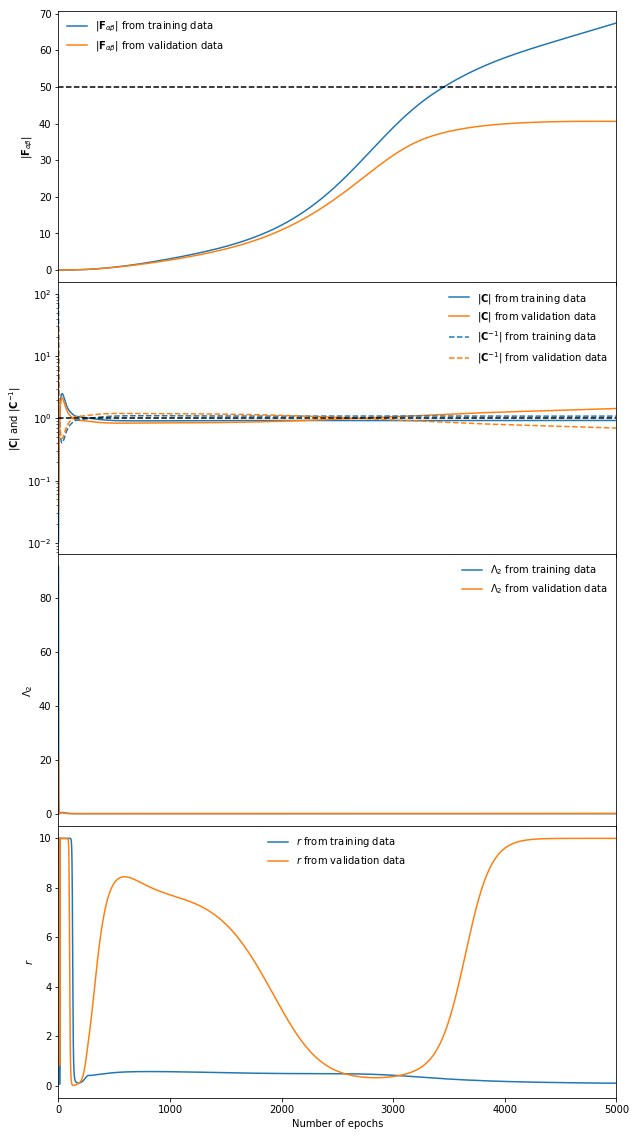

In [43]:
fig, ax = plt.subplots(4, 1, sharex = True, figsize = (10, 20))
plt.subplots_adjust(hspace = 0)
epochs = np.arange(1, len(imnn.history["det_F"]) + 1)
ax[0].plot(epochs, imnn.history["det_F"], color="C0",
           label=r'$|{\bf F}_{\alpha\beta}|$ from training data')
ax[0].plot(epochs, imnn.history["val_det_F"], color="C1",
           label=r'$|{\bf F}_{\alpha\beta}|$ from validation data')
ax[0].axhline(determinant_exact_fisher, color="black", linestyle="dashed")
ax[0].legend(frameon=False)
ax[0].set_xlim([1, epochs[-1]])
ax[0].set_ylabel(r"$|{\bf F}_{\alpha\beta}|$")
ax[1].plot(epochs, imnn.history["det_C"], color="C0",
           label=r'$|{\bf C}|$ from training data')
ax[1].plot(epochs, imnn.history["val_det_C"], color="C1",
           label=r'$|{\bf C}|$ from validation data')
ax[1].plot(epochs, imnn.history["det_Cinv"], color="C0", linestyle="dashed",
           label=r'$|{\bf C}^{-1}|$ from training data')
ax[1].plot(epochs, imnn.history["val_det_Cinv"], color="C1", linestyle="dashed",
           label=r'$|{\bf C}^{-1}|$ from validation data')
ax[1].axhline(1., color="black", linestyle="dashed")
ax[1].legend(frameon=False, loc="best")
ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
ax[1].set_xlim([1, epochs[-1]])
ax[1].set_yscale("log")
ax[2].plot(epochs, imnn.history["reg"],
           label=r'$\Lambda_2$ from training data')
ax[2].plot(epochs, imnn.history["val_reg"],
           label=r'$\Lambda_2$ from validation data')
ax[2].legend(frameon=False)
ax[2].set_ylabel(r"$\Lambda_2$")
ax[2].set_xlim([1, epochs[-1]])
ax[3].plot(epochs, imnn.history["r"], 
           label=r'$r$ from training data')
ax[3].plot(epochs, imnn.history["val_r"], 
           label=r'$r$ from validation data')
ax[3].legend(frameon=False)
ax[3].set_ylabel(r"$r$")
ax[3].set_xlim([1, epochs[-1]])
ax[3].set_xlabel("Number of epochs");

## Maximum likelihood estimates

The IMNN can provide maximum likelihood estimates of model parameters by initialising

In [44]:
imnn.setup_MLE()

Note this only works when a validation set is already loaded. It uses the validation set to calculate the Fisher information, covariance, derivative of the mean summaries and therefore the compression and transformation into MLE space. If a different dataset is to be used then it can be provided by setting `dataset=False` and providing all the necessary extra data
```python
imnn.setup_MLE(dataset=True, θ_fid=None, d=None, dd_dθ=None, δθ=None, s=None, ds_dθ=None)
```

The maxmimum likelihood estimate is then obtained by running `imnn.get_MLE(d)` on data `d`

In [45]:
print("The maximum likelihood estimate of the real data is " + str(imnn.get_MLE(real_data)[0].numpy()))

The maximum likelihood estimate of the real data is [1.8213251 4.3077555]


## Approximate Bayesian computation

We can now do ABC (or PMC-ABC) with our calculated summary. From the samples we create simulations at each parameter value and feed each simulation through the network to get summaries. The summaries are compared to the summary of the real data to find the distances which can be used to accept or reject points.

We start by defining our prior as a truncated Gaussian (uniform is also available). The uniform function is taken from delfi by Justin Alsing. At some point in the near future (for a given value of "near") this whole module will upgraded to TensorFlow Probability and complete TensorFlow 2 implementation. 

We are going to choose the mean value of the variance to be 1 with a variance of the variance of 10 cut at 0 and 10.

In [46]:
prior = priors.TruncatedGaussian(np.array([0., 1.]), np.array([[10., 0.], [0., 10.]]), np.array([-10., 0.]), np.array([10., 10.]))

The ABC module takes in the _observed_ data, the prior and the function for obtaining the MLE from the IMNN as well as the Fisher information matrix used for obtaining the MLE. It also takes in the simulator and its arguments.

In [47]:
abc = ABC(real_data=real_data, prior=prior, F=imnn.MLE_F, get_MLE=imnn.get_MLE, simulator=simulator, seed=None, simulator_args={"input shape": input_shape})

## Gaussian approximation
Before running all the simulations need for approximate Bayesian computation, we can get the Gaussian approximation of the posterior from the MLE and the inverse Fisher information.

maximum likelihood estimate [1.8213251 4.3077555]
determinant of the Fisher information 67.50628


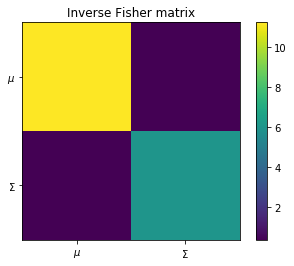

In [48]:
print("maximum likelihood estimate", abc.MLE[0])
print("determinant of the Fisher information", np.linalg.det(abc.F))
plt.imshow(np.linalg.inv(abc.Finv))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

In [49]:
gaussian_approximation, grid = abc.gaussian_approximation(gridsize = 100)

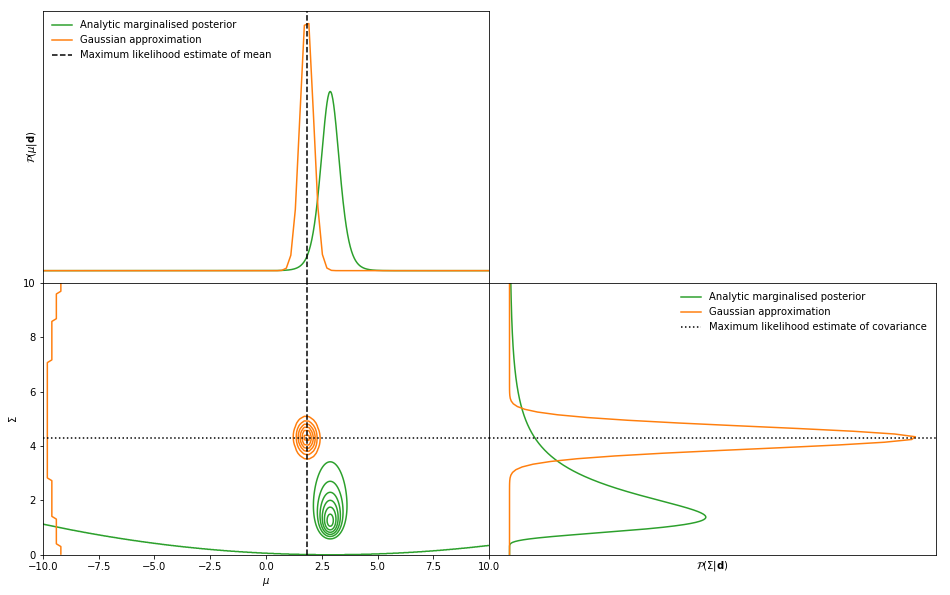

In [50]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We can see that the maximum likelihood estimate for the mean is almost perfect whilst it is incorrect for the variance. However, we can now see the ABC does in its place.

### ABC
The most simple ABC takes the number of draws and a switch to state whether to run all the simulations in parallel or sequentially. The full simulations can also be saved by passing a file name. The draws are stored in the class attribute `ABC_dict`.

In [51]:
abc.ABC(draws=100000, at_once=True, save_sims=None)

In ABC, draws are accepted if the distance between the simulation summary and the simulation of the real data are "close", i.e. smaller than some ϵ value, which is chosen somewhat arbitrarily.

In [53]:
ϵ = .5
accept_indices = np.argwhere(abc.ABC_dict["distances"] < ϵ)[:, 0]
reject_indices = np.argwhere(abc.ABC_dict["distances"] >= ϵ)[:, 0]
print("Number of accepted samples = ", accept_indices.shape[0])

Number of accepted samples =  2319


### Plot samples
We can plot the output samples and the histogram of the accepted samples, which should peak around `θ = 1` (where we generated the real data). The monotonic function of all the output samples shows that the network has learned how to summarise the data.

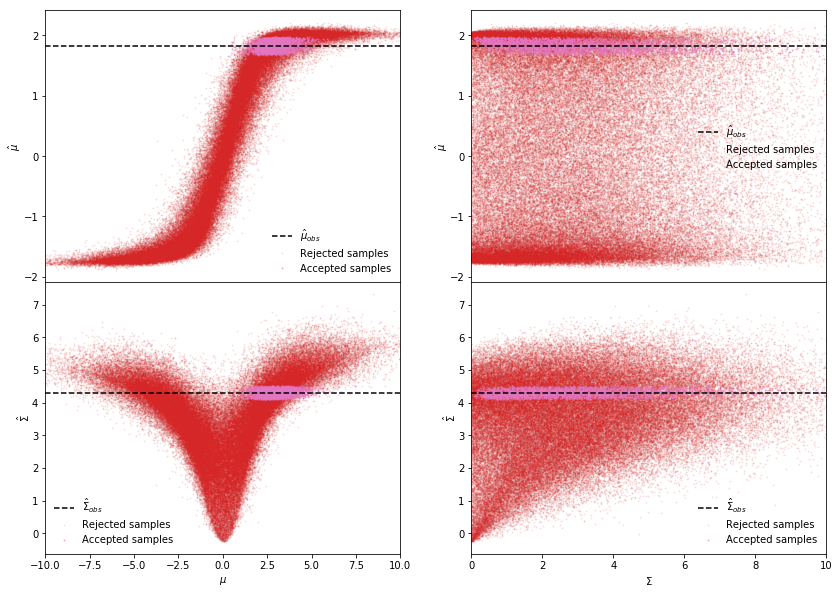

In [54]:
fig, ax = plt.subplots(2, 2, figsize = (14, 10))
plt.subplots_adjust(hspace = 0, wspace = 0.2)
ax[0, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["MLE"][reject_indices, 0], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[0, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0] , abc.ABC_dict["MLE"][accept_indices, 0], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[0, 0].axhline(abc.MLE[0, 0], color = 'black', linestyle = 'dashed', label = "$\hat{\mu}_{obs}$")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel('$\hat{\mu}$', labelpad = 0)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_xticks([])
ax[1, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["MLE"][reject_indices, 1], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0] , abc.ABC_dict["MLE"][accept_indices, 1], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[1, 0].axhline(abc.MLE[0, 1], color = 'black', linestyle = 'dashed', label = "$\hat{\Sigma}_{obs}$")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_ylabel('$\hat{\Sigma}$', labelpad = 0)
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].set_xlabel("$\mu$")
ax[0, 1].scatter(abc.ABC_dict["parameters"][reject_indices, 1], abc.ABC_dict["MLE"][reject_indices, 0], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[0, 1].scatter(abc.ABC_dict["parameters"][accept_indices, 1] , abc.ABC_dict["MLE"][accept_indices, 0], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[0, 1].axhline(abc.MLE[0, 0], color = 'black', linestyle = 'dashed', label = "$\hat{\mu}_{obs}$")
ax[0, 1].legend(frameon=False)
ax[0, 1].set_ylabel('$\hat{\mu}$', labelpad = 0)
ax[0, 1].set_xlim([0, 10])
ax[0, 1].set_xticks([])
ax[1, 1].scatter(abc.ABC_dict["parameters"][reject_indices, 1], abc.ABC_dict["MLE"][reject_indices, 1], s = 1, alpha = 0.1, label = "Rejected samples", color = "C3")
ax[1, 1].scatter(abc.ABC_dict["parameters"][accept_indices, 1] , abc.ABC_dict["MLE"][accept_indices, 1], s = 1, label = "Accepted samples", color = "C6", alpha = 0.5)
ax[1, 1].axhline(abc.MLE[0, 1], color = 'black', linestyle = 'dashed', label = "$\hat{\Sigma}_{obs}$")
ax[1, 1].legend(frameon=False)
ax[1, 1].set_ylabel('$\hat{\Sigma}$', labelpad = 0)
ax[1, 1].set_xlim([0, 10])
ax[1, 1].set_xlabel("$\Sigma$");

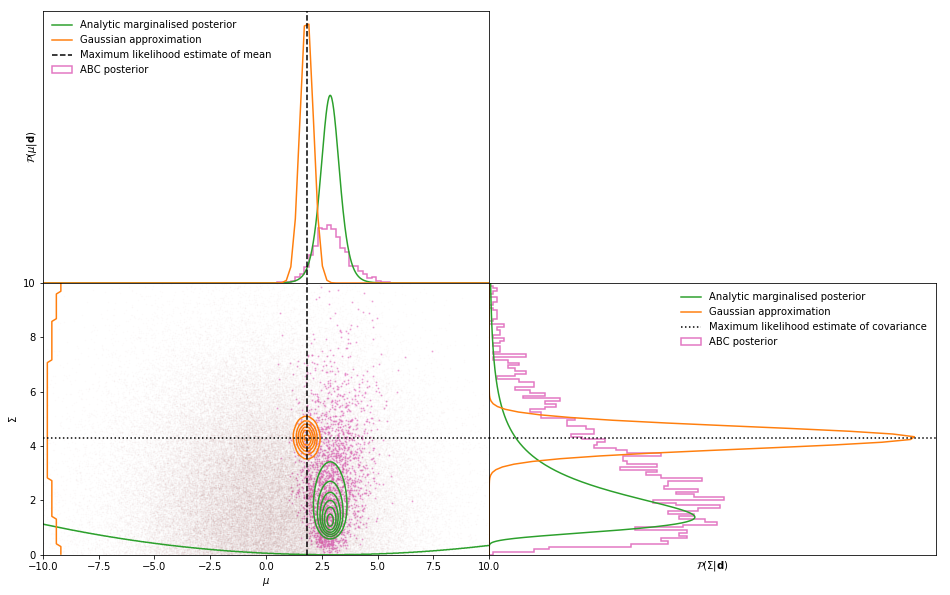

In [55]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].hist(abc.ABC_dict["parameters"][accept_indices, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0], abc.ABC_dict["parameters"][accept_indices, 1], color = "C6", s = 1, alpha = 0.5)
ax[1, 0].scatter(abc.ABC_dict["parameters"][reject_indices, 0], abc.ABC_dict["parameters"][reject_indices, 1], color = "C3", s = 1, alpha = 0.01)
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].hist(abc.ABC_dict["parameters"][accept_indices, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C6", label = "ABC posterior");
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We now get samples from the posterior disrtibution which is not too far from the analytic posterior, and is at least unbiased. However, many samples are rejected to achieve this, and the rejection is defined somewhat arbitrarily, making it very computationally heavy and uncertain. We can improve on this using a PMC.

## PMC-ABC
Population Monte Carlo ABC is a way of reducing the number of draws by first sampling from a prior, accepting the closest 75% of the samples and weighting all the rest of the samples to create a new proposal distribution. The furthest 25% of the original samples are redrawn from the new proposal distribution. The furthest 25% of the simulation summaries are continually rejected and the proposal distribution updated until the number of draws needed accept all the 25% of the samples is much greater than this number of samples. This ratio is called the criterion. 

If we want 1000 samples from the approximate distribution at the end of the PMC we need to set `posterior = 1000`. The initial random draw (as in ABC above) initialises with `draws`, the larger this is the better proposal distribution will be on the first iteration.

The `PMC` can be continued by running again with a smaller criterion. 

In [56]:
abc.PMC(draws=2000, posterior=2000, criterion=0.01, at_once=True, save_sims=None) 

To restart the PMC from scratch then one can run
```python
abc.PMC(draws=1000, posterior=1000, criterion=0.01, at_once=True, save_sims=None, restart=True) 
```

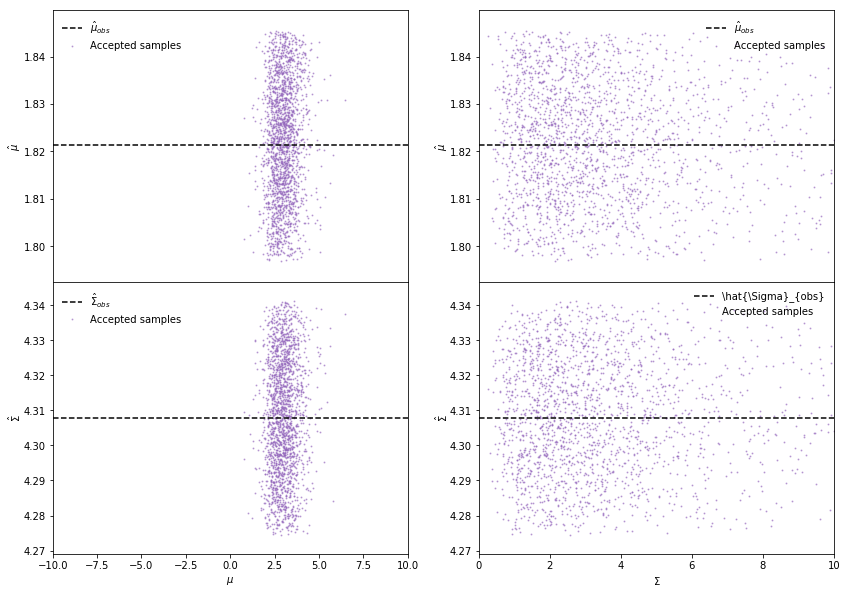

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0, wspace=0.2)
ax[0, 0].scatter(abc.PMC_dict["parameters"][:, 0] , abc.PMC_dict["MLE"][:, 0], s=1, label="Accepted samples", color="C4", alpha=0.5)
ax[0, 0].axhline(abc.MLE[0, 0], color='black', linestyle='dashed', label="$\hat{\mu}_{obs}$")
ax[0, 0].legend(frameon=False)
ax[0, 0].set_ylabel('$\hat{\mu}$', labelpad=0)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_xticks([])
ax[1, 0].scatter(abc.PMC_dict["parameters"][:, 0], abc.PMC_dict["MLE"][:, 1], s=1, alpha=0.5, label="Accepted samples", color="C4")
ax[1, 0].axhline(abc.MLE[0, 1], color='black', linestyle='dashed', label="$\hat{\Sigma}_{obs}$")
ax[1, 0].legend(frameon=False)
ax[1, 0].set_ylabel('$\hat{\Sigma}$', labelpad=0)
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].set_xlabel("$\mu$")
ax[0, 1].scatter(abc.PMC_dict["parameters"][:, 1], abc.PMC_dict["MLE"][:, 0], s=1, alpha=0.5, label="Accepted samples", color="C4")
ax[0, 1].axhline(abc.MLE[0, 0], color='black', linestyle='dashed', label="$\hat{\mu}_{obs}$")
ax[0, 1].legend(frameon=False)
ax[0, 1].set_ylabel('$\hat{\mu}$', labelpad=0)
ax[0, 1].set_xlim([0, 10])
ax[0, 1].set_xticks([])
ax[1, 1].scatter(abc.PMC_dict["parameters"][:, 1], abc.PMC_dict["MLE"][:, 1], s=1, alpha=0.5, label="Accepted samples", color="C4")
ax[1, 1].axhline(abc.MLE[0, 1], color='black', linestyle='dashed', label="\hat{\Sigma}_{obs}")
ax[1, 1].legend(frameon=False)
ax[1, 1].set_ylabel('$\hat{\Sigma}$', labelpad=0)
ax[1, 1].set_xlim([0, 10])
ax[1, 1].set_xlabel("$\Sigma$");

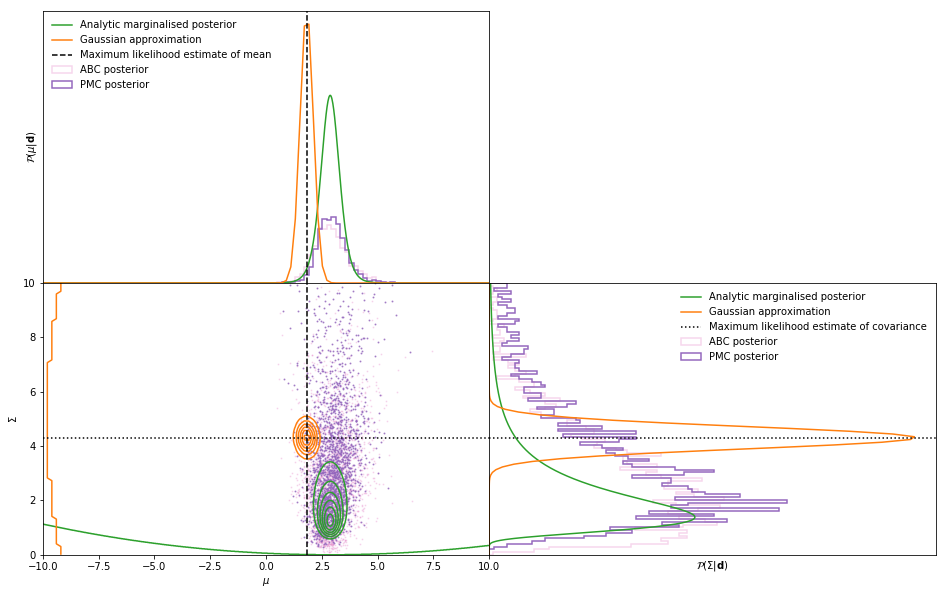

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].hist(abc.ABC_dict["parameters"][accept_indices, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C6", alpha = 0.3, label = "ABC posterior");
ax[0, 0].hist(abc.PMC_dict["parameters"][:, 0], np.linspace(-10, 10, 100), histtype = u'step', density = True, linewidth = 1.5, color = "C4", label = "PMC posterior");
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].scatter(abc.ABC_dict["parameters"][accept_indices, 0], abc.ABC_dict["parameters"][accept_indices, 1], color = "C6", s = 1, alpha = 0.2)
ax[1, 0].scatter(abc.PMC_dict["parameters"][:, 0], abc.PMC_dict["parameters"][:, 1], color = "C4", s = 1, alpha = 0.7)
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].hist(abc.ABC_dict["parameters"][accept_indices, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C6", alpha = 0.3, label = "ABC posterior");
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].hist(abc.PMC_dict["parameters"][:, 1], np.linspace(0, 10, 100), histtype = u'step', orientation="horizontal", density = True, linewidth = 1.5, color = "C4", label = "PMC posterior");
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");

We can see that the IMNN can recover great posteriors even when the data is extremely far from the fiducial parameter value at which the network was trained! Woohoo - give yourself a pat on the back!